In [1]:
import numpy as np
import mne
from mne.datasets import sample
import numpy as np

import mne
mne.set_log_level(verbose='CRITICAL')
from mne.datasets import multimodal
from mne import channels, evoked, create_info
import matplotlib.pyplot as plt

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import scipy.signal as sl
from typing import Optional
import scipy as sp
import sys
from nilearn import plotting
sys.path.insert(1, os.path.realpath(os.path.pardir))
from deepmeg.experimental.models import SPIRIT
from deepmeg.data.datasets import EpochsDataset, read_epochs_dataset
from torch.utils.data import DataLoader
from deepmeg.preprocessing.transforms import zscore
import torch
from collections import defaultdict
import torchmetrics
from deepmeg.training.callbacks import Callback, EarlyStopping, L2Reg, PrintingCallback
from deepmeg.experimental.interpreters import SPIRITInterpreter
import random
import torch.nn as nn
from deepmeg.models.interpretable import BaseModel


def plot_metrics(metrics: dict[str, np.ndarray]):
    plot_dict = defaultdict(dict)

    for metric, values in metrics.items():
        metric_data = metric.split('_')
        metric_name = '_'.join(metric_data[:-1])
        metric_kind = metric_data[-1]
        plot_dict[metric_name][metric_kind] = values

    for metric_name, kind_dict in plot_dict.items():
        legend = list()
        for metric_kind, kind in kind_dict.items():
            plt.plot(kind)
            legend.append(metric_kind)
        plt.title(metric_name)
        plt.legend(legend)
        plt.show()

def accuracy(predictions, targets):

    # Convert one-hot encoded labels to class indices
    targets = torch.argmax(targets, dim=1)

    # Compute predicted class indices
    _, predicted = torch.max(predictions, dim=1)

    # Compute accuracy
    correct = torch.sum(predicted == targets)
    total = targets.shape[0]
    accuracy = correct / total

    return accuracy


In [ ]:
from mne.datasets import multimodal
fname_raw = os.path.join(multimodal.data_path(), 'multimodal_raw.fif')
info = mne.io.read_raw_fif(fname_raw).resample(600).pick_types(meg='grad').info

In [2]:
dataset = read_epochs_dataset('../data/multimodal.pt')
train, test = torch.utils.data.random_split(dataset, [.7, .3])
x, y = next(iter(DataLoader(test, len(test))))
y.shape

torch.Size([282, 8])

In [5]:
kwargs = dict(
    n_channels=x.shape[1],
    n_times=x.shape[-1],
    filter_size=50,
    n_latent=8,
    pool_factor=10,
    n_outputs=y.shape[-1]
)

In [6]:
class LFCNN(BaseModel):

    def __init__(
        self,
        n_channels: int,
        n_times: int,
        n_latent: int,
        filter_size: int,
        pool_factor: int,
        n_outputs: int
    ):
        super().__init__()
        self.pool_factor = pool_factor
        self.n_latent = n_latent
        self.unmixing_layer = nn.Linear(n_channels, n_latent, bias=True)
        self.temp_conv = nn.Conv1d(n_latent, n_latent, kernel_size=filter_size, bias=True, groups=n_latent, padding='same')
        final_out_features = (n_times//pool_factor)*n_latent if not n_times%pool_factor else (n_times//pool_factor + 1)*n_latent
        self.fc_layer = nn.Linear(final_out_features, n_outputs)


    def forward(self, x: torch.Tensor):
        x = self.unmixing_layer(x.permute(0, -1, 1))
        x = self.temp_conv(x.permute(0, -1, 1))
        x = x[:, :, ::self.pool_factor].contiguous()
        x = torch.flatten(x, 1)
        return self.fc_layer(x)

X = torch.rand((1, 204, 301))

LFCNN(204, 301, 8, 50, 10, 8)(X)

tensor([[-0.0344, -0.0062,  0.0126,  0.0091, -0.0267, -0.0482,  0.0101, -0.0161]],
       grad_fn=<AddmmBackward0>)

In [7]:
model = LFCNN(
    **kwargs
)

optimizer = torch.optim.Adam
loss = torch.nn.BCEWithLogitsLoss()
metric = accuracy

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(), # print ongoing training history
        EarlyStopping(patience=15, monitor='loss_val', restore_best_weights=True), # perform early stopping with restoring best weights
        L2Reg(
            [
                'unmixing_layer.weight',
                'temp_conv.weight',
            ], lambdas=.01
        ) # l2 regularization for weights of spatial- and temporal filtering layers
    ]
)

Epoch 0:  loss_train:  0.7251   |    accuracy_train:  0.1326   |    loss_val:  0.7100   |    accuracy_val:  0.1427
Epoch 1:  loss_train:  0.7038   |    accuracy_train:  0.1648   |    loss_val:  0.6893   |    accuracy_val:  0.1805
Epoch 2:  loss_train:  0.6806   |    accuracy_train:  0.2141   |    loss_val:  0.6638   |    accuracy_val:  0.2027
Epoch 3:  loss_train:  0.6528   |    accuracy_train:  0.2661   |    loss_val:  0.6325   |    accuracy_val:  0.1867
Epoch 4:  loss_train:  0.6194   |    accuracy_train:  0.3032   |    loss_val:  0.5961   |    accuracy_val:  0.2253
Epoch 5:  loss_train:  0.5810   |    accuracy_train:  0.3177   |    loss_val:  0.5575   |    accuracy_val:  0.2742
Epoch 6:  loss_train:  0.5402   |    accuracy_train:  0.3369   |    loss_val:  0.5214   |    accuracy_val:  0.2849
Epoch 7:  loss_train:  0.5015   |    accuracy_train:  0.3448   |    loss_val:  0.4922   |    accuracy_val:  0.2794
Epoch 8:  loss_train:  0.4683   |    accuracy_train:  0.3712   |    loss_val:  0

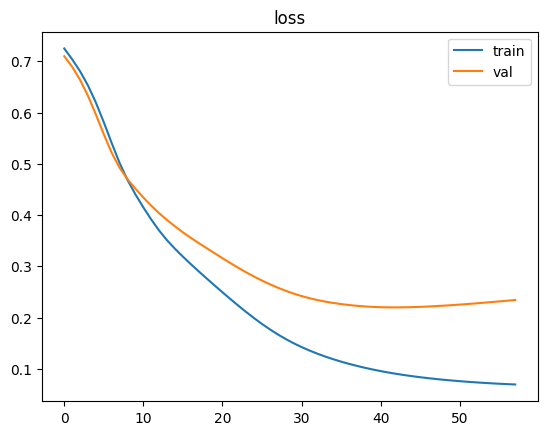

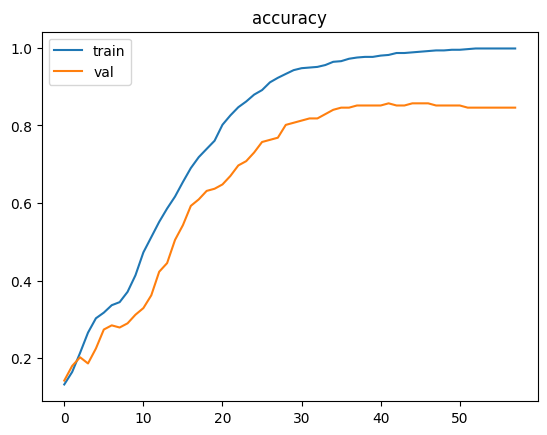

In [8]:
history = model.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [9]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.11924602497707713
train_accuracy: 0.956643359227614
loss: 0.2182621495290236
accuracy: 0.8636363636363636


In [255]:
list(map(lambda x: x[0], model.named_parameters()))

['unmixing_layer.weight',
 'unmixing_layer.bias',
 'compressing_layer.weight',
 'compressing_layer.bias',
 'temp_conv.weight',
 'temp_conv.bias',
 'fc_layer.weight',
 'fc_layer.bias']

In [3]:
def get_sizes(m, n, k):
    if n >= m or k <= 0:
        return []

    base_diff = (m - n) / (k + 1)
    bases = []

    for i in range(k + 1):
        base = n + i * base_diff
        bases.append(int(base))

    bases.append(m)
    return bases[::-1]


In [4]:
class mCSPLFCNN(BaseModel):

    def __init__(
        self,
        n_channels: int,
        n_times: int,
        n_latent: int,
        n_layers: int,
        filter_size: int,
        pool_factor: int,
        n_outputs: int
    ):
        super().__init__()
        fc_sizes = get_sizes(n_channels, n_latent, n_layers)
        self.pool_factor = pool_factor
        self.n_latent = n_latent
        # self.unmixing_layer = nn.Linear(n_channels, n_latent, bias=True)
        self.unmixing_layer = nn.Sequential(
            *[nn.Linear(in_, out, bias=True) for in_, out in zip(fc_sizes[:-1], fc_sizes[1:])]
        )
        self.temp_conv = nn.Conv1d(n_latent, n_latent, kernel_size=filter_size, bias=True, groups=n_latent, padding='same')
        final_out_features = (n_times//pool_factor)*n_latent if not n_times%pool_factor else (n_times//pool_factor + 1)*n_latent
        self.fc_layer = nn.Linear(final_out_features, n_outputs)


    def forward(self, x: torch.Tensor):
        x = self.unmixing_layer(x.permute(0, -1, 1))
        x = self.temp_conv(x.permute(0, -1, 1))
        x = x[:, :, ::self.pool_factor].contiguous()
        x = torch.flatten(x, 1)
        return self.fc_layer(x)

X = torch.rand((1, 204, 301))

mCSPLFCNN(204, 301, 8, 4, 50, 10, 8)(X)

/home/user/Projects/deepmeg/venv/lib/python3.11/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1003.)
  return F.conv1d(input, weight, bias, self.stride,


tensor([[ 0.1453, -0.0278, -0.0528, -0.0414,  0.0831,  0.0095, -0.0412,  0.0071]],
       grad_fn=<AddmmBackward0>)

In [8]:
model = mCSPLFCNN(
    n_channels=x.shape[1],
    n_times=x.shape[-1],
    filter_size=50,
    n_latent=8,
    n_layers=3,
    pool_factor=10,
    n_outputs=y.shape[-1]
)

optimizer = torch.optim.Adam
loss = torch.nn.BCEWithLogitsLoss()
metric = accuracy

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(), # print ongoing training history
        EarlyStopping(patience=15, monitor='loss_val', restore_best_weights=True), # perform early stopping with restoring best weights
        L2Reg(
            [
                # *[f'unmixing_layer.{i}.weight' for i in range(4)],
                'temp_conv.weight',
            ], lambdas=.01
        ) # l2 regularization for weights of spatial- and temporal filtering layers
    ]
)

In [11]:
list(map(lambda x: x[0], model.named_parameters()))

['unmixing_layer.0.weight',
 'unmixing_layer.0.bias',
 'unmixing_layer.1.weight',
 'unmixing_layer.1.bias',
 'unmixing_layer.2.weight',
 'unmixing_layer.2.bias',
 'unmixing_layer.3.weight',
 'unmixing_layer.3.bias',
 'temp_conv.weight',
 'temp_conv.bias',
 'fc_layer.weight',
 'fc_layer.bias']

In [9]:
if hasattr(sys.stdout, 'file'):
    sys.stdout = sys.stdout.file

Epoch 0:  loss_train:  0.6990   |    accuracy_train:  0.1809   |    loss_val:  0.6793   |    accuracy_val:  0.2142
Epoch 1:  loss_train:  0.6646   |    accuracy_train:  0.2624   |    loss_val:  0.6397   |    accuracy_val:  0.2360
Epoch 2:  loss_train:  0.6152   |    accuracy_train:  0.3076   |    loss_val:  0.5791   |    accuracy_val:  0.2742
Epoch 3:  loss_train:  0.5433   |    accuracy_train:  0.3257   |    loss_val:  0.4951   |    accuracy_val:  0.2797
Epoch 4:  loss_train:  0.4598   |    accuracy_train:  0.3350   |    loss_val:  0.4221   |    accuracy_val:  0.3290
Epoch 5:  loss_train:  0.4016   |    accuracy_train:  0.3558   |    loss_val:  0.3893   |    accuracy_val:  0.3246
Epoch 6:  loss_train:  0.3632   |    accuracy_train:  0.3833   |    loss_val:  0.3605   |    accuracy_val:  0.3582
Epoch 7:  loss_train:  0.3313   |    accuracy_train:  0.4258   |    loss_val:  0.3467   |    accuracy_val:  0.3530
Epoch 8:  loss_train:  0.3074   |    accuracy_train:  0.4917   |    loss_val:  0

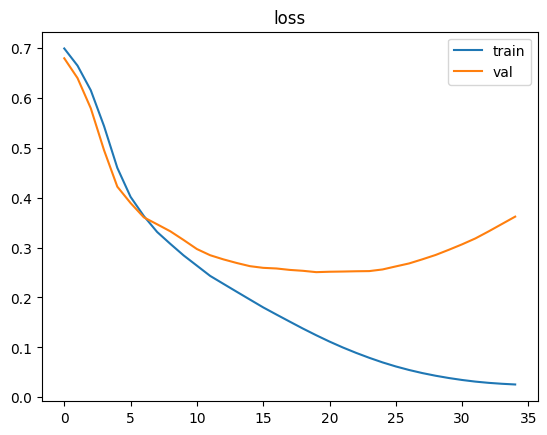

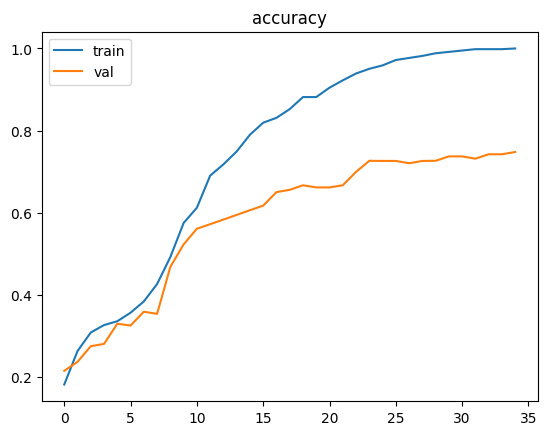

In [10]:
history = model.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [11]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.15546673129905353
train_accuracy: 0.8388111970641396
loss: 0.23756020177494397
accuracy: 0.7337662306698886
